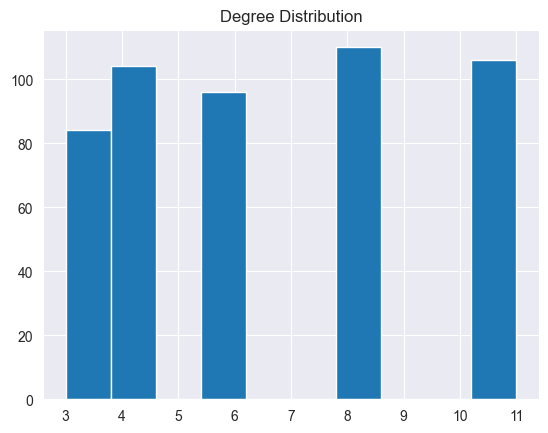

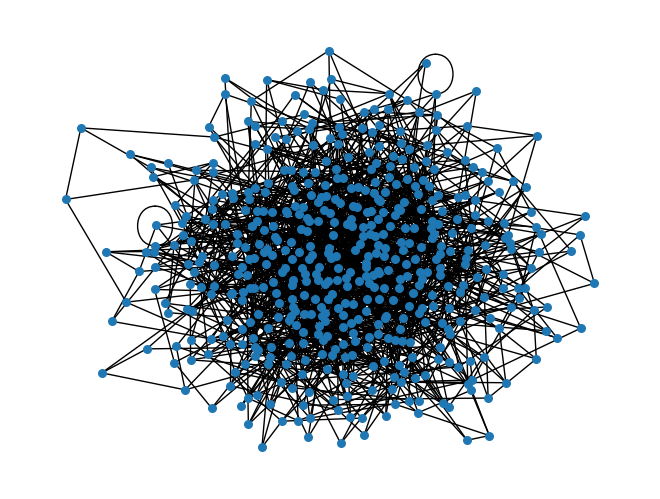

In [6]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



def generate_graph_deg_dist(deg_dist, n):
    deg = list(deg_dist.keys())
    proba = list(deg_dist.values())
    if sum(proba) == 1.:
        deg_sequence = np.random.choice(
            deg,
            n,
            proba
        )

        if sum(deg_sequence) % 2 != 0:
            # to ensure that the degree sequence is always even for the configuration model
            deg_sequence[1] = deg_sequence[1] + 1

        return nx.configuration_model(deg_sequence)
    raise ValueError("Probabilities do not equal to 1")

G = generate_graph_deg_dist(
        deg_dist = {
            6:0.2,
            3:0.14,
            8:0.35,
            4:0.3,
            11:0.01
        },
        n = 500
)

#print(nx.info(G))

# visualize degree distribution
plt.clf()
plt.hist(list(dict(G.degree()).values()))
plt.title('Degree Distribution')
plt.show()

# visualize the network -- do not run this step if your network is very large with a lot of edges
nx.draw(G, node_size = 30)

In [7]:
%%time

from node2vec import Node2Vec
g_emb = Node2Vec(G,dimensions=16,walk_length=100,num_walks=20,q=1,p=2)

mdl = g_emb.fit(window=5, min_count=3)

emb_df = (
    pd.DataFrame(
        [mdl.wv.get_vector(str(n)) for n in G.nodes()],
        index = G.nodes
    )
)

Computing transition probabilities:   0%|          | 0/500 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 20/20 [00:03<00:00,  6.07it/s]


CPU times: total: 6.53 s
Wall time: 17.6 s


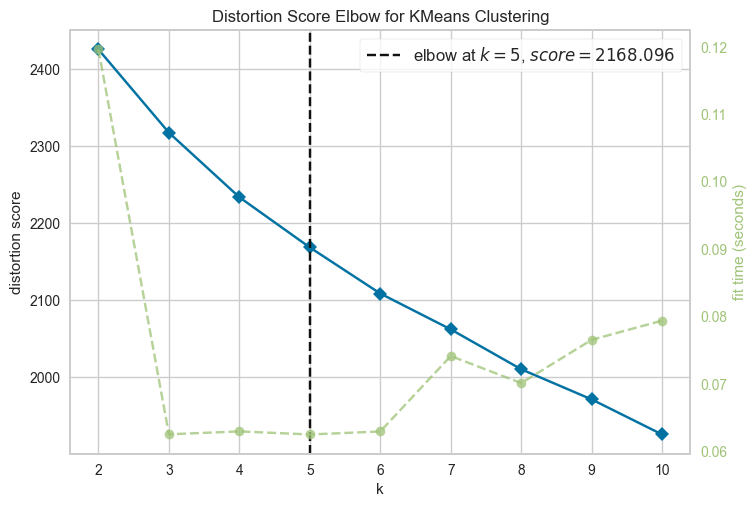

KMeans(n_clusters=10, n_init=10)


In [8]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import  KMeans

X = emb_df.values
kmeans = KMeans(n_init=10)
sil_vis = KElbowVisualizer(kmeans,numeric_only=None)
sil_vis.fit(X)
sil_vis.show()
print(kmeans)

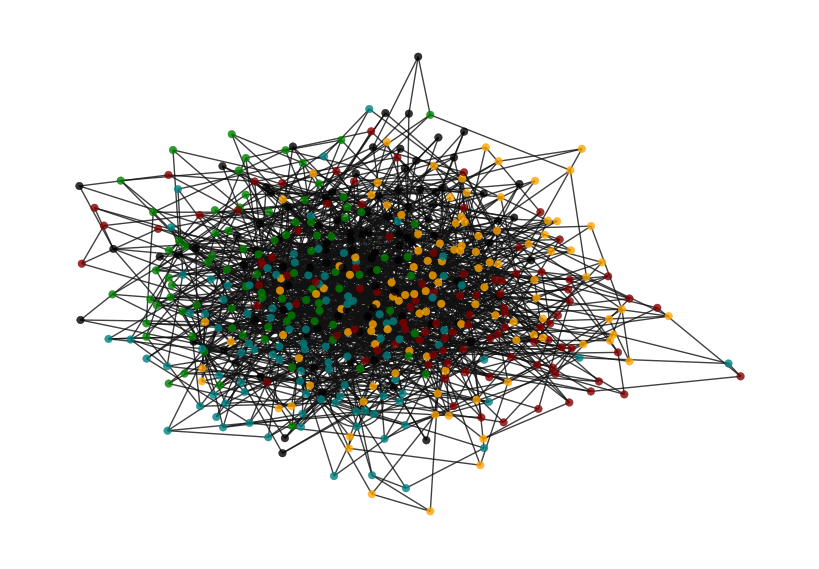

In [9]:

kmeans = KMeans(n_init=10,n_clusters=5)
kmeans.fit(X)
comm_dct = dict(zip(emb_df.index, kmeans.labels_))

unique_coms = np.unique(list(comm_dct.values()))
cmap = {
    0 : 'maroon',
    1 : 'teal',
    2 : 'black',
    3 : 'orange',
    4 : 'green',
}

node_cmap = [cmap[v] for _,v in comm_dct.items()]

pos = nx.spring_layout(G)
nx.draw(G, pos, node_size = 30, alpha = 0.8, node_color=node_cmap)
plt.show()


<Axes: xlabel='0', ylabel='1'>

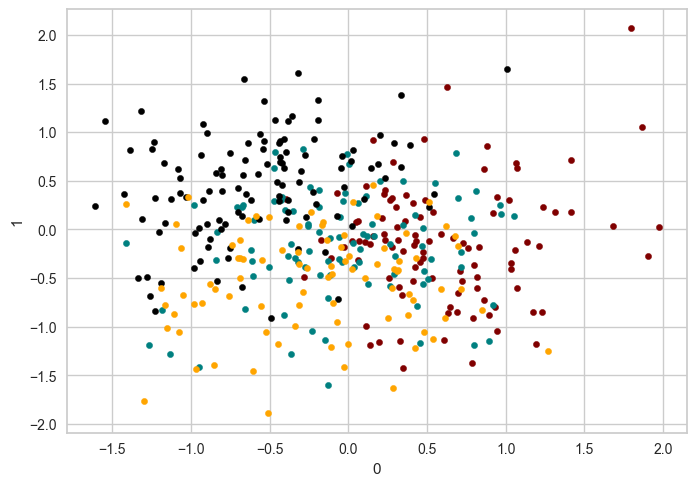

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
df_pca = pd.DataFrame(pca.fit_transform(emb_df))
df_pca['Cluster'] = kmeans.labels_
cmap = {
    0 : 'maroon',
    1 : 'teal',
    2 : 'black',
    3 : 'orange',
    4 : 'green',
}
df1 = df_pca[df_pca["Cluster"]==1]
df2 = df_pca[df_pca["Cluster"]==2]
df3 = df_pca[df_pca["Cluster"]==3]
df4 = df_pca[df_pca["Cluster"]==4]
df5 = df_pca[df_pca["Cluster"]==5]

ax = df1.plot.scatter(x = 0, y = 1, c = cmap[0])
df2.plot.scatter(x = 0, y = 1, c = cmap[1],ax=ax)
df3.plot.scatter(x = 0, y = 1, c = cmap[2],ax=ax)
df4.plot.scatter(x = 0, y = 1, c = cmap[3],ax=ax)
df5.plot.scatter(x = 0, y = 1, c = cmap[4],ax=ax)


array([[<Axes: title={'center': 'degree'}>]], dtype=object)

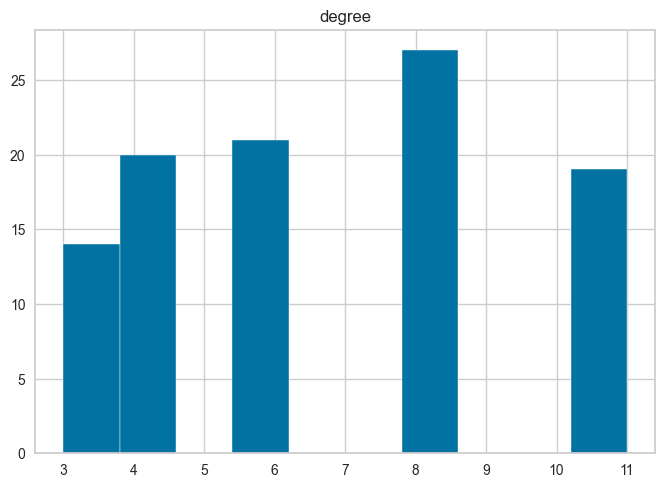

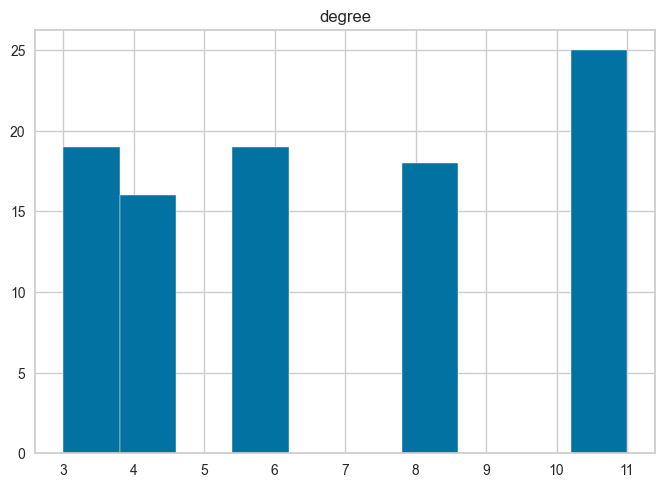

In [11]:
deg =[]
for row in df1.index:
    deg.append( G.degree(row))
df1_deg = pd.DataFrame(deg,columns=['degree'])
deg =[]
for row in df2.index:
    deg.append( G.degree(row))
df2_deg = pd.DataFrame(deg,columns=['degree'])
#print(df1_deg)
df1_deg.hist()
df2_deg.hist()